In [1]:
import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC/'
pncdemo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
race = []
sex = []
age = []

for sub in pncdemo['age_at_cnb']:
    try:
        ra = pncdemo['Race'][sub]
        ag = pncdemo['age_at_cnb'][sub]
        se = pncdemo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{pncdir}/fc/{sub}_task-rest_fc.npy')
        n = np.load(f'{pncdir}/fc/{sub}_task-nback_fc.npy')
        e = np.load(f'{pncdir}/fc/{sub}_task-emoid_fc.npy')
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(r)
        nback.append(n)
        emoid.append(e)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

print([a.shape for a in [rest, nback, emoid, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193,), (1193,), (1193,)]


In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

class Imputer(nn.Module):
    def __init__(self):
        super(Imputer, self).__init__()
        self.fc1 = nn.Linear(20, 200).float().cuda()
        self.fc2 = nn.Linear(34716, 2000).float().cuda()
        self.fc3 = nn.Linear(2200, 34716).float().cuda()

    def forward(self, x, noise):
        n = F.relu(self.fc1(noise))
        x = F.relu(self.fc2(x))
        x = torch.cat([n, x], dim=1)
        x = self.fc3(x)
        return x.squeeze()

imp = Imputer()
optim = torch.optim.Adam(imp.parameters(), lr=1e-4, weight_decay=1e-4)

def gen_samp(x, y, n):
    noise = torch.randn(n, 20).float().cuda()
    x = x.unsqueeze(0).tile((n,1))
    y = y.unsqueeze(0).tile((n,1))
    return x, y, noise

def div_loss(x):
    d = torch.cdist(x,x,p=2)+torch.eye(len(x),len(x)).float().cuda()
    loss = torch.sum(1/d)
    return loss

def rmse(x, y):
    return torch.mean((x-y)**2)**0.5

def reg_loss(x):
    loss = torch.mean(torch.exp(torch.abs(x)))
    return loss

def truth_loss(x, y):
    mx = torch.linalg.norm(x,dim=1,keepdims=True)
    my = torch.linalg.norm(y,dim=1,keepdims=True)
    cos = torch.sum(x*y/mx/my, dim=1)
    loss = 1/torch.sum(torch.exp(cos/0.5))
    # cos = torch.mean((x-y)**2,dim=1)**0.5
    # loss = 1/torch.sum(torch.exp(0.05/cos))
    return loss

nepochs = 10
pperiod = 100

xtr, xt, ytr, yt = train_test_split(rest, nback, train_size=800)

xtr = torch.from_numpy(xtr).float().cuda()
ytr = torch.from_numpy(ytr).float().cuda()

xt = torch.from_numpy(xt).float().cuda()
yt = torch.from_numpy(yt).float().cuda()

for e in range(nepochs):
    for i in range(len(xtr)):
        optim.zero_grad()
        x, y, n = gen_samp(xtr[i], ytr[i], 10)
        yhat = imp(x, n)
        l1 = 1*div_loss(yhat)
        l2 = 1*reg_loss(yhat)
        l3 = 100*truth_loss(yhat, y)
        loss = l1+l2+l3
        loss.backward()
        optim.step()
        if i % pperiod == 0:
            print(f'{e} {i} {l1} {l2} {l3}')
        
print('Done')

0 0 16.040874481201172 1.0911190509796143 9.992452621459961
0 100 14.012641906738281 1.8424572944641113 1.9303653240203857
0 200 12.922447204589844 1.3360708951950073 2.271625518798828
0 300 12.518829345703125 1.417731761932373 1.8726872205734253
0 400 11.964460372924805 1.6871980428695679 2.2569217681884766
0 500 11.735372543334961 1.65544593334198 2.289588689804077
0 600 11.700186729431152 1.5791289806365967 1.8740191459655762
0 700 11.639466285705566 1.647780179977417 2.070796012878418
1 0 11.433615684509277 2.103362798690796 1.779289722442627
1 100 11.583281517028809 1.5133534669876099 2.2947838306427
1 200 11.30874252319336 1.558121919631958 2.6358964443206787
1 300 11.247774124145508 1.7595524787902832 1.971744418144226
1 400 11.304901123046875 1.9000208377838135 2.3400533199310303
1 500 11.413688659667969 1.650311827659607 2.402627944946289
1 600 11.408973693847656 1.5841186046600342 2.001087188720703
1 700 11.246513366699219 1.6258949041366577 2.35477614402771
2 0 11.3300228118

In [13]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [238]:
yhatnp = []
xnp = []
ynp = []

with torch.no_grad():
    for i in range(len(xt)):
        x, y, n = gen_samp(xt[i], yt[i], 10)
        yhat = imp(x,n)
        yhatnp.append(yhat.detach().cpu().numpy())
        xnp.append(xt[i].detach().cpu().numpy())
        ynp.append(yt[i].detach().cpu().numpy())

print('Done')

Done


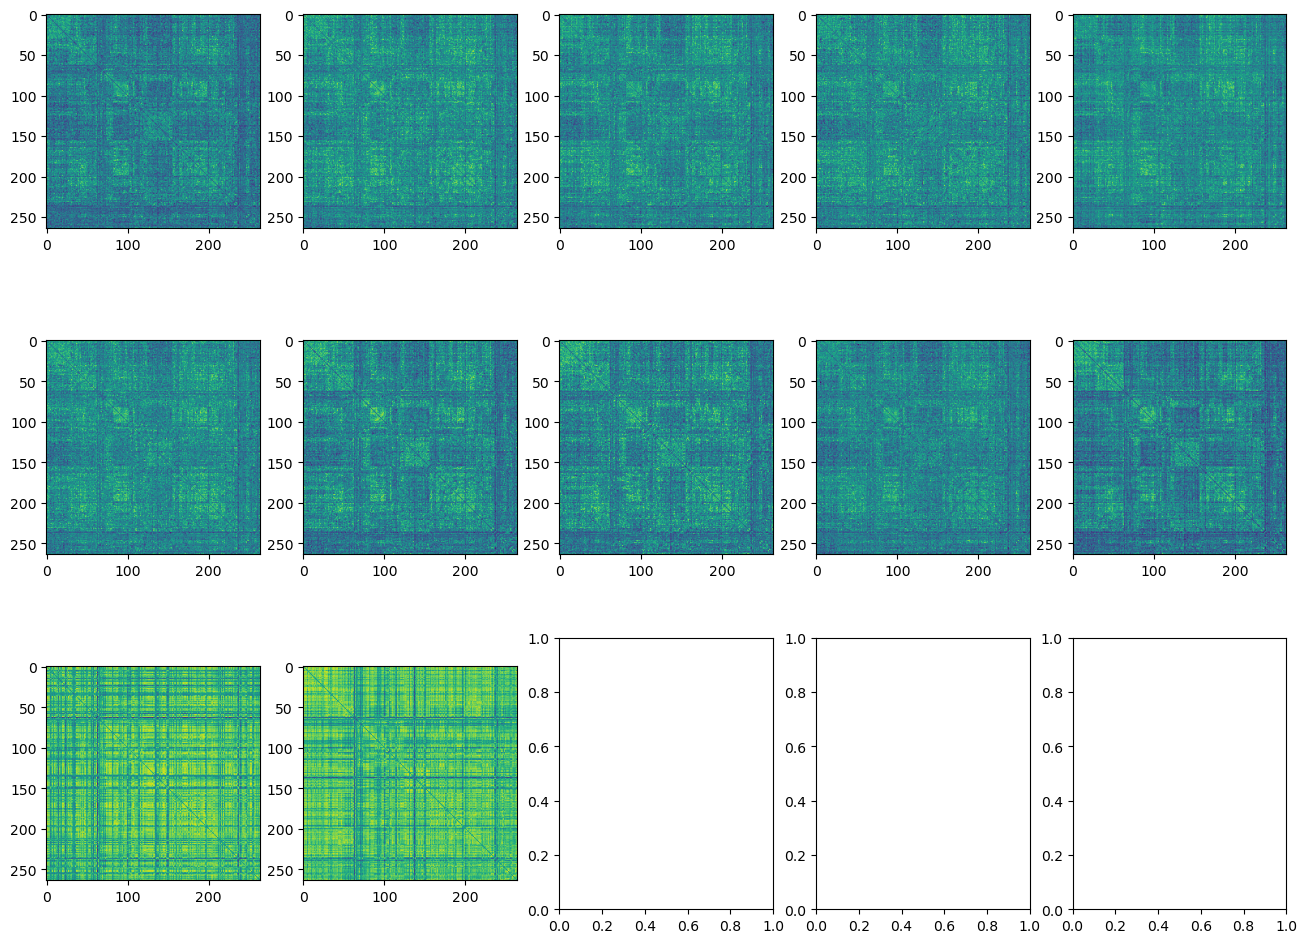

In [243]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,5,figsize=(16,12))

subi = 1

for i in range(2):
    for j in range(5):
        ax[i,j].imshow(remap(vec2mat(yhatnp[subi][i*5+j])))

ax[2,0].imshow(remap(vec2mat(xnp[subi])))
ax[2,1].imshow(remap(vec2mat(ynp[subi])))

fig.show()

In [166]:
yhatnp[subi][0]-yhatnp[subi][2]

array([-0.11531067,  0.7451248 , -0.8014784 , ..., -1.0136871 ,
        1.4926949 ,  0.81516266], dtype=float32)